# TP – DDPM on Two Moons (Solution Version)

This notebook walks through the implementation of a Denoising Diffusion Probabilistic Model (DDPM)
applied to the Two Moons dataset. The goal is to help students understand the core components
of diffusion models through hands-on coding and visualization. 

We will:
1. Build and visualize the Two Moons dataset (centered and rescaled).
2. Implement several beta schedules and a reusable `NoiseScheduler` class.
3. Visualize the noisy data for different timesteps.
4. Explore positional/time embeddings and inspect them graphically.
5. Assemble the MLP score network and verify intermediate tensors.
6. Train with a DDPM objective (MSE on predicted noise) using `tqdm`.
7. Sample new points, compare to the dataset, and export GIF animations of the reverse process.
8. Run a lightweight ablation on embeddings / schedules.

The students are expected to fill in the missing code sections marked with `# TODO` comments.




In [1]:
import math
import random
from pathlib import Path

import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_moons
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import tqdm

# ------------------------------------------------------------------
# Reproducibility and device
# ------------------------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

cfg = {
    "num_samples": 8000,
    "noise": 0.03,
    "batch_size": 512,
    "num_timesteps": 1000,
    "beta_start": 1e-4,
    "beta_end": 2e-2,
    "beta_schedule": "linear",  # {linear, quadratic, cosine}
    "hidden_size": 128,
    "hidden_layers": 3,
    "emb_size": 128,
    "lr": 2e-4,
    "num_epochs": 1000,
    "eval_every": 250,
    "sample_points": 1024,
}
print(cfg)

Running on cuda
{'num_samples': 8000, 'noise': 0.03, 'batch_size': 512, 'num_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02, 'beta_schedule': 'linear', 'hidden_size': 128, 'hidden_layers': 3, 'emb_size': 128, 'lr': 0.0002, 'num_epochs': 1000, 'eval_every': 250, 'sample_points': 1024}


## 1. Dataset preparation and visualization
We rely on `sklearn.make_moons`, then we **center and rescale** each axis so that
points cover approximately the square `[-1, 1]^2` (exactly as in `ddpm.ipynb`).


<font color='blue'>**TODO:**</font>
- Load the Two Moons dataset with the specified noise level.
- Apply the exact shift/rescale used in `ddpm.ipynb` so both axes live in [-1, 1].
- Wrap the numpy array into a `TensorDataset` and prepare a shuffled `DataLoader`.


In [2]:
def moons_dataset(n_samples=cfg["num_samples"], noise=cfg["noise"], seed=SEED):
    """Return a TensorDataset with normalized Two Moons coordinates."""
    X, _ = make_moons(n_samples=n_samples, noise=noise, random_state=seed)
    X = X.astype(np.float32)
    # TODO: center and rescale both axes to approximately fit in [-1, 1]
    X[:, 0] = (X[:, 0] - 0.5) / 1.55
    X[:, 1] = (X[:, 1] - 0.25) / 0.85

    return TensorDataset(torch.from_numpy(X))


train_dataset = moons_dataset()
train_loader = DataLoader(
    train_dataset,
    batch_size=cfg["batch_size"],
    shuffle=True,
    drop_last=True,
)

print(f"Dataset size: {len(train_dataset)} samples")
print(
    f"Mimimum and maximum of the samples:\n {train_dataset.tensors[0].min(0).values}\n {train_dataset.tensors[0].max(0).values}"
)

Dataset size: 8000 samples
Mimimum and maximum of the samples:
 tensor([-1.0030, -0.9666])
 tensor([1.0258, 0.9775])


### 1.1. Quick scatter helper
We often want to compare the raw dataset with noisy samples or generated points.
`scatter_data_and_samples` overlays both sets and annotates the timestep.
Students will trigger it after prepping the dataset.

<font color='blue'>**TODO:**</font>
- Write a helper that scatters the dataset and optional generated samples on the same axes.
- Use the scatter function from `matplotlib.pyplot` to plot points.
- Fix the axis limits to `[-1.5, 1.5]` for better visibility.


In [3]:
def scatter_data_and_samples(
    data,
    samples=None,
    title="Two Moons",
    label=None,
    figsize=(5, 5),
    alpha_real=0.5,
    alpha_fake=0.6,
):
    # TODO: plot dataset and optional samples on the same scatter chart
    if isinstance(data, TensorDataset):
        pts = data.tensors[0].cpu()
    else:
        pts = data.detach().cpu() if torch.is_tensor(data) else data

    pts = pts.clamp(-1.5, 1.5)  # TODO

    plt.figure(figsize=figsize)
    plt.scatter(
        pts[:, 0], pts[:, 1], s=6, alpha=alpha_real, label="dataset", c="#1f77b4"
    )  # TODO
    if samples is not None:
        samples = samples.detach().cpu()
        plt.scatter(
            samples[:, 0],
            samples[:, 1],
            s=6,
            alpha=alpha_fake,
            label="samples",
            c="#ff7f0e",
        )  # TODO
    plt.xlim(-1.5, 1.5)  # TODO
    plt.ylim(-1.5, 1.5)  # TODO
    title_suffix = f" {label}" if label is not None else ""
    plt.title(f"{title}{title_suffix}")
    plt.legend()
    plt.show()

### 1.2. Visual inspection of the normalized data

<font color='blue'>**TODO:**</font>
- Call `scatter_data_and_samples` right after building the dataset to visually sanity check the scaling.


<font color='blue'>**TODO:**</font> Run next cell to try your code.


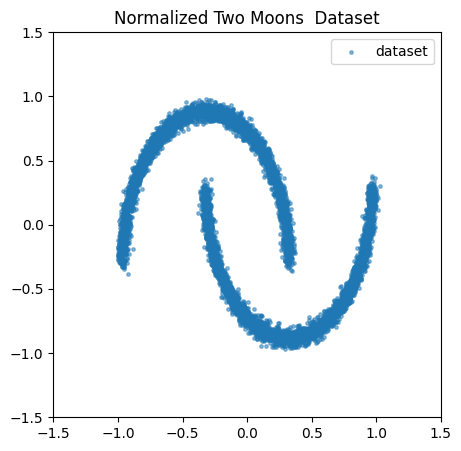

In [4]:
# TODO: visualize the dataset to verify scaling
scatter_data_and_samples(train_dataset, title="Normalized Two Moons", label=" Dataset")

## 2. Noise schedules and diffusion coefficients
The forward diffusion process is controlled by a sequence $\{\beta_t\}_{t=1}^T$ called the noise schedule.
Given $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$, the
forward process satisfies:
$$
q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \sqrt{\alpha_t} x_{t-1}, \beta_t I), \qquad
q(x_t \mid x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I).
$$
Below we implement three schedules so students can compare them.

Let use call `beta_start` and `beta_end` the initial and final beta values, respectively.
- **Linear schedule:** $\beta_t$ increases linearly from `beta_start` to `beta_end`.
- **Quadratic schedule:** $\beta_t$ increases quadratically from `beta_start` to `beta_end`.
- **Cosine schedule:** $\beta_t$ follows a cosine schedule as in Nichol & Dhariwal (2021):
    $$
    \bar{\alpha}_t = \frac{f(t/T)}{f(0)}, \quad \text{where } f(s) = \cos\left(\frac{s + 0.008}{1.008} \cdot \frac{\pi}{2}\right)^2.
    $$
    Then $\beta_t = 1 -  \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}$ with $\bar{\alpha}_0 = 1$. In practice, we clip $\beta_t$ to a maximum of 0.999.
    

<font color='blue'>**TODO:**</font>
- Implement linear, quadratic, and cosine beta schedules that return tensors of shape `(T,)`.


In [5]:
# TODO: implement multiple beta schedules (linear, quadratic, cosine)
def linear_beta_schedule(num_timesteps, beta_start, beta_end):
    return torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32)


def quadratic_beta_schedule(num_timesteps, beta_start, beta_end):
    betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_timesteps)
    return betas.pow(2).float()


def cosine_beta_schedule(num_timesteps, s=0.008):
    steps = num_timesteps + 1
    x = torch.linspace(0, num_timesteps, steps, dtype=torch.float32)
    alphas = torch.cos(((x / num_timesteps) + s) / (1 + s) * math.pi / 2) ** 2
    alphas = alphas / alphas[0]
    betas = 1 - (alphas[1:] / alphas[:-1])
    return betas.clamp(0.0001, 0.9999)

<font color='blue'>**TODO:**</font> Run the next cell to try your code.

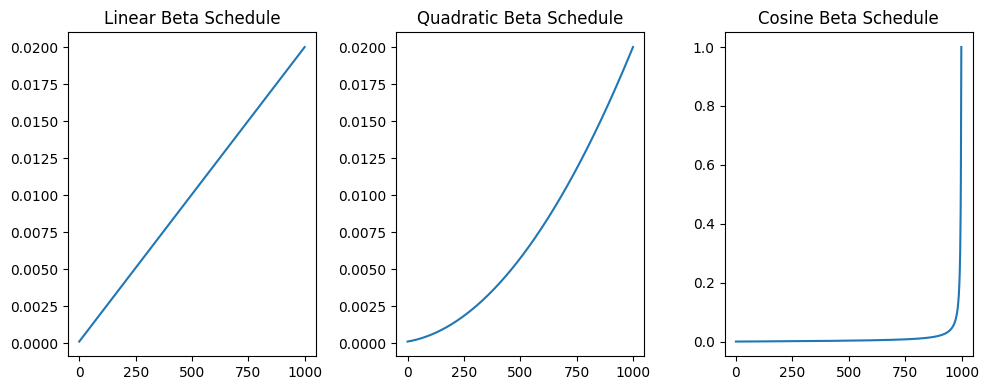

In [6]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(linear_beta_schedule(cfg["num_timesteps"], cfg["beta_start"], cfg["beta_end"]))
plt.title("Linear Beta Schedule")
plt.subplot(1, 3, 2)
plt.plot(
    quadratic_beta_schedule(cfg["num_timesteps"], cfg["beta_start"], cfg["beta_end"])
)
plt.title("Quadratic Beta Schedule")
plt.subplot(1, 3, 3)
plt.plot(cosine_beta_schedule(cfg["num_timesteps"]))
plt.title("Cosine Beta Schedule")
plt.tight_layout()
plt.show()

Using the $\beta_t$ schedules, we can compute and plot the corresponding $\bar{\alpha}_t$ sequences:
$$ \bar{\alpha}_t = \prod_{s=1}^t (1 - \beta_s). $$


### 2.1. NoiseScheduler helper class

We will build a `NoiseScheduler` class to encapsulate the noise schedule and precompute all necessary diffusion coefficients. We will progressively add methods to this class as we implement the DDPM components.

You will need to implement the following methods using the DDPM equations:
- `add_noise(x0, eps, t)` implements: $$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon.$$
- `reconstruct_x0(x_t, t, eps_theta)` implements the denoising prediction:
$$\hat{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - \sqrt{1 - \bar{\alpha}_t} \epsilon_\theta(x_t, t) \right).$$
- `q_posterior(x0, x_t, t)` computes the mean of $q(x_{t-1} \mid x_t, x_0)$:
$$\mu_q = \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1 - \bar{\alpha}_t} x_0 + \frac{\sqrt{\alpha_t} (1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t.$$
- `step(model_output, t, x_t)` performs a single reverse update:
$$x_{t-1} = \mu_q + \sigma_t \epsilon, \quad \text{where } \sigma_t^2 = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t.$$


We precompute all necessary coefficients in the `__init__` method for efficiency:
- `betas`: $\beta_t$ for $t=1,\ldots,T$
- `alphas`: $\alpha_t = 1 - \beta_t$ for $t=1,\ldots,T$
- `alphas_cumprod`: $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$ for $t=1,\ldots,T$
- `alphas_cumprod_prev`: $\bar{\alpha}_{t-1}$  for $t=1,\ldots,T$ with $\bar{\alpha}_0 = 1$
- `sqrt_alphas_cumprod`: $\sqrt{\bar{\alpha}_t}$ for $t=1,\ldots,T$
- `sqrt_one_minus_alphas_cumprod`: $\sqrt{1 - \bar{\alpha}_t}$ for $t=1,\ldots,T$
- `sqrt_recip_alphas_cumprod`: $\frac{1}{\sqrt{\bar{\alpha}_t}}$ for $t=1,\ldots,T$
- `sqrt_recipm1_alphas_cumprod`: $\sqrt{\frac{1}{\bar{\alpha}_t} - 1}$ for $t=1,\ldots,T$
- `posterior_variance`: $\sigma_t^2 = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t$ for $t=1,\ldots,T$
- `posterior_mean_coef1`: $\frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1 - \bar{\alpha}_t}$ for $t=1,\ldots,T$
- `posterior_mean_coef2`: $\frac{\sqrt{\alpha_t} (1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t}$ for $t=1,\ldots,T$


In this class, you will also need a helper method `_extract` to broadcast timestep-dependent scalars over arbitrary batch shapes:
```python
example_coeff = self._extract(self.alphas_cumprod, t, x_t.shape)
```

<font color='blue'>**TODO:**</font>
- Implement `add_noise`, `reconstruct_x0`, `q_posterior`, and `step` exactly as in the DDPM equations.
- Use a helper like `_extract` to broadcast timestep-dependent scalars over arbitrary batch shapes.


In [7]:
class NoiseScheduler:
    def __init__(
        self,
        num_timesteps=cfg["num_timesteps"],
        beta_start=cfg["beta_start"],
        beta_end=cfg["beta_end"],
        schedule_type=cfg["beta_schedule"],
    ):
        # TODO: pick the requested schedule and pre-compute diffusion coefficients
        if schedule_type == "linear":
            betas = linear_beta_schedule(num_timesteps, beta_start, beta_end)
        elif schedule_type == "quadratic":
            betas = quadratic_beta_schedule(num_timesteps, beta_start, beta_end)
        elif schedule_type == "cosine":
            betas = cosine_beta_schedule(num_timesteps)
        else:
            raise ValueError(f"Unknown schedule: {schedule_type}")

        self.num_timesteps = num_timesteps
        self.betas = betas
        self.alphas = 1.0 - betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        self.posterior_variance = (
            betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        ).clamp(min=1e-20)
        self.posterior_mean_coef1 = (
            betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )

    def _extract(self, arr, timesteps, x_shape):
        batch = timesteps.shape[0]
        out = arr.to(timesteps.device)[timesteps]
        return out.view(batch, *([1] * (len(x_shape) - 1)))

    def add_noise(self, x0, noise, timesteps):
        # TODO: apply forward diffusion formula
        sqrt_alpha = self._extract(self.sqrt_alphas_cumprod, timesteps, x0.shape)
        sqrt_one_minus = self._extract(
            self.sqrt_one_minus_alphas_cumprod, timesteps, x0.shape
        )
        return sqrt_alpha * x0 + sqrt_one_minus * noise

    def reconstruct_x0(self, x_t, timesteps, noise):
        # TODO: reconstruct x0 from x_t and predicted noise
        sqrt_recip = self._extract(self.sqrt_recip_alphas_cumprod, timesteps, x_t.shape)
        sqrt_recipm1 = self._extract(
            self.sqrt_recipm1_alphas_cumprod, timesteps, x_t.shape
        )
        return sqrt_recip * x_t - sqrt_recipm1 * noise

    def q_posterior(self, x0, x_t, timesteps):
        # TODO: compute posterior mean for q(x_{t-1} | x_t, x0)
        coef1 = self._extract(self.posterior_mean_coef1, timesteps, x_t.shape)
        coef2 = self._extract(self.posterior_mean_coef2, timesteps, x_t.shape)
        return coef1 * x0 + coef2 * x_t

    def step(self, model_output, timesteps, sample):
        # TODO: implement one reverse step (Eq. 11 in DDPM paper)
        x0 = self.reconstruct_x0(sample, timesteps, model_output)
        model_mean = self.q_posterior(x0, sample, timesteps)
        variance = self._extract(self.posterior_variance, timesteps, sample.shape)
        noise = torch.randn_like(sample)
        nonzero_mask = (timesteps != 0).float().view(-1, *([1] * (sample.dim() - 1)))
        return model_mean + nonzero_mask * torch.sqrt(variance) * noise

    def __len__(self):
        return self.num_timesteps

### 2.2. Visual comparison of schedules

<font color='blue'>**TODO:**</font>
- Plot every schedule on the same matplotlib figure to highlight how their alphas ramps differ.


<font color='blue'>**TODO:**</font> Run next cell to try your code.


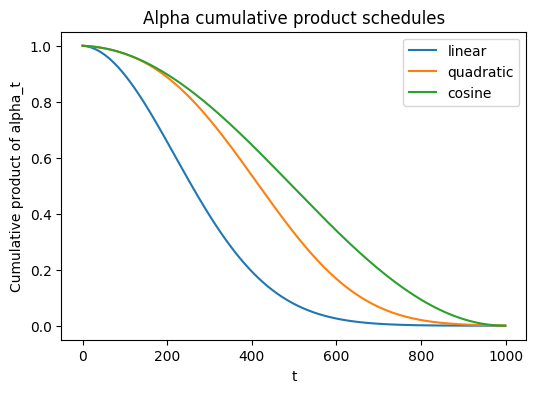

In [8]:
# TODO: plot the beta curves for each schedule to compare shapes
lin = NoiseScheduler(schedule_type="linear")
quad = NoiseScheduler(schedule_type="quadratic")
cos = NoiseScheduler(schedule_type="cosine")
plt.figure(figsize=(6, 4))
plt.plot(lin.alphas_cumprod, label="linear")
plt.plot(quad.alphas_cumprod, label="quadratic")
plt.plot(cos.alphas_cumprod, label="cosine")
plt.title("Alpha cumulative product schedules")
plt.xlabel("t")
plt.ylabel("Cumulative product of alpha_t")
plt.legend()
plt.show()

### 2.3. Inspect noising for different timesteps
For a batch of real samples we can directly compute $x_t$ at arbitrary timesteps:
$$
x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon.
$$
This diagnostic plot helps spot mistakes in the forward process.

<font color='blue'>**TODO:**</font>
- Write a function that takes a few real points, corrupts them at several timesteps, and shows the scatter side-by-side.
- Verify visually that larger `t` corresponds to heavier noise (nearly Gaussian at `t=T-1`).


<font color='blue'>**TODO:**</font> Run next cell to try your code.


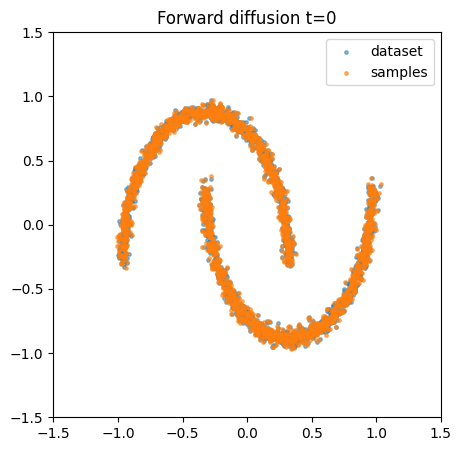

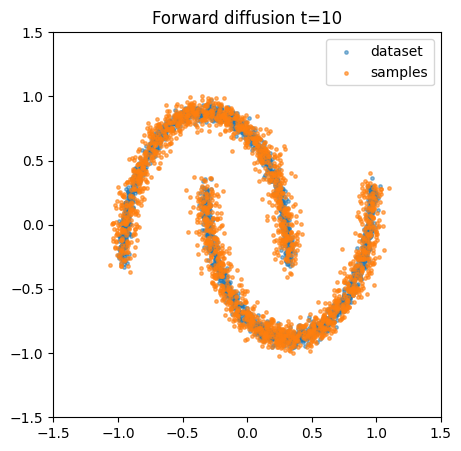

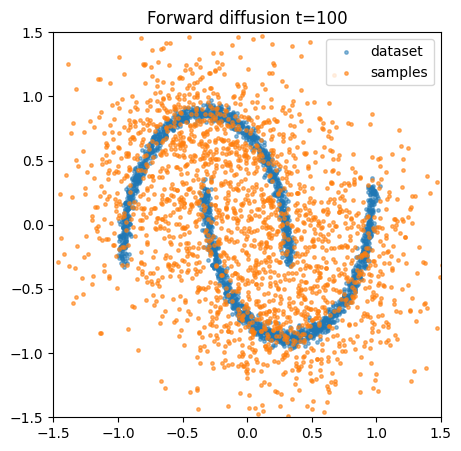

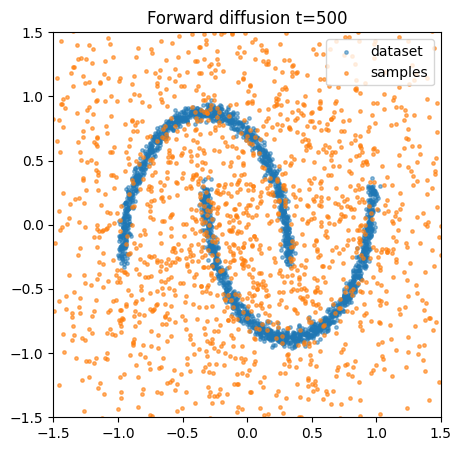

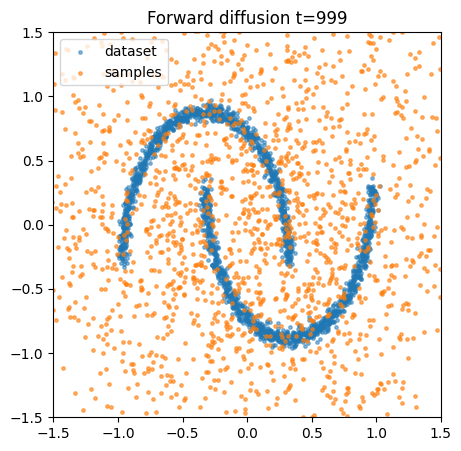

In [9]:
# TODO: visualize forward diffusion at multiple timesteps
def visualize_forward_process(
    dataset, scheduler, steps=(0, 50, 200, 400, 999), n_points=2048
):
    base = dataset.tensors[0]
    idx = torch.randperm(len(base))[:n_points]
    base = base[idx].to(device)
    for t in steps:
        noise = torch.randn_like(base)
        timesteps = torch.full((base.shape[0],), t, device=device, dtype=torch.long)
        x_t = scheduler.add_noise(base, noise, timesteps)
        scatter_data_and_samples(
            base.cpu(), samples=x_t, title="Forward diffusion", label=f"t={t}"
        )


visualize_forward_process(train_dataset, lin, steps=(0, 10, 100, 500, 999))

## 3. Positional and time embeddings
The MLP consumes $(x, y, t)$ but benefits from richer features. Following the standard
DDPM/Transformer recipe we combine several embeddings. For the sinusoidal one we use:
$$
	\text{Sinusoidal}(t, k) = \sin\left( 
\frac{t}{10000^{2k / d}} 
\right), \quad
	\text{Sinusoidal}(t, k + d/2) = \cos\left( 
\frac{t}{10000^{2k / d}} 
\right).
$$

Other embeddings include:
- **Linear embedding:** scales `t` linearly to `[-1, 1]`.
- **Learnable embedding:** a learnable `nn.Embedding` layer. 
- **Identity embedding:** simply returns `t` as a float tensor.
- **Zero embedding:** returns a tensor of zeros.

<font color='blue'>**TODO:**</font>
- Ensure the sinusoidal embedding matches the Transformer-style equation provided above.
- Looking at the sinusoidal embedding code, implement the other positional embeddings (linear, learnable, identity, zero).


In [10]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half = self.size // 2
        freq = torch.exp(
            -math.log(10000.0) * torch.arange(half, device=x.device) / (half - 1)
        )
        angles = x.unsqueeze(-1) * freq.unsqueeze(0)
        emb = torch.cat((torch.sin(angles), torch.cos(angles)), dim=-1)
        return emb

    def __len__(self):
        return self.size


class LinearEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        return (x / self.size * self.scale).unsqueeze(-1)  # TODO

    def __len__(self):
        return 1


class LearnableEmbedding(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.size = size
        self.linear = nn.Linear(1, size)

    def forward(self, x: torch.Tensor):
        return self.linear(x.unsqueeze(-1))  # TODO

    def __len__(self):
        return self.size


class IdentityEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.size = 1

    def __len__(self):
        return 1

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1)  # TODO


class ZeroEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.size = 1

    def __len__(self):
        return 1

    def forward(self, x: torch.Tensor):
        return torch.zeros_like(x).unsqueeze(-1)  # TODO


class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, emb_type: str, **kwargs):
        super().__init__()
        if emb_type == "sinusoidal":
            self.layer = SinusoidalEmbedding(size, **kwargs)
        elif emb_type == "linear":
            self.layer = LinearEmbedding(size, **kwargs)
        elif emb_type == "learnable":
            self.layer = LearnableEmbedding(size)
        elif emb_type == "identity":
            self.layer = IdentityEmbedding()
        elif emb_type == "zero":
            self.layer = ZeroEmbedding()
        else:
            raise ValueError(f"Unknown embedding type: {emb_type}")

    def forward(self, x: torch.Tensor):
        x = self.layer(x)
        if x.shape[-1] != self.layer.size:
            x = x.unsqueeze(-1)
        return x

    def __len__(self):
        return len(self.layer)

### 3.1. Visualization utility for embeddings

<font color='blue'>**TODO:**</font>
- Plot a handful of embedding dimensions versus normalized time to understand their dynamics before training.


<font color='blue'>**TODO:**</font> Run next cell to try your code.


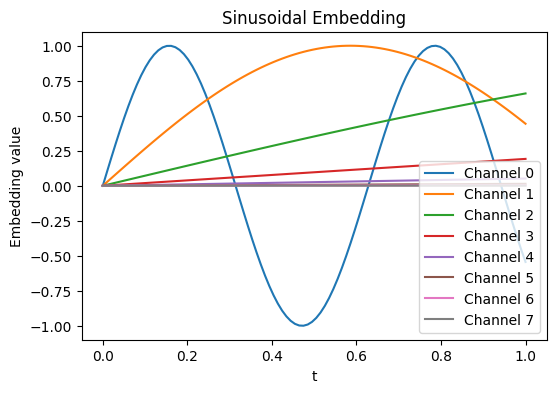

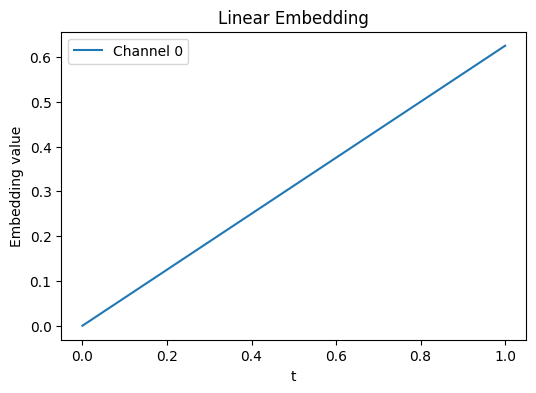

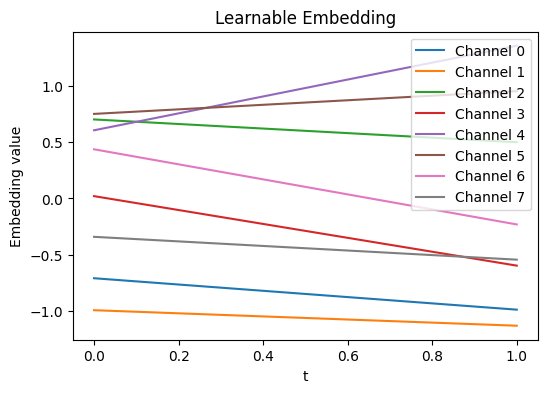

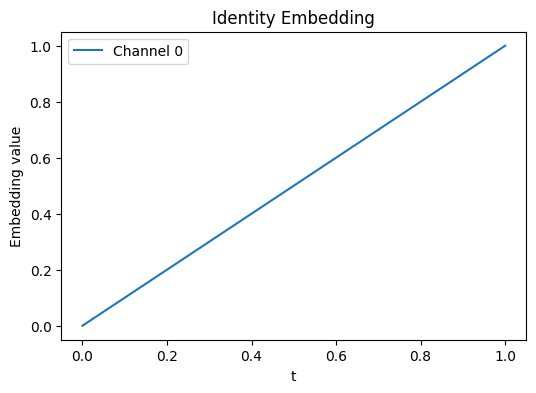

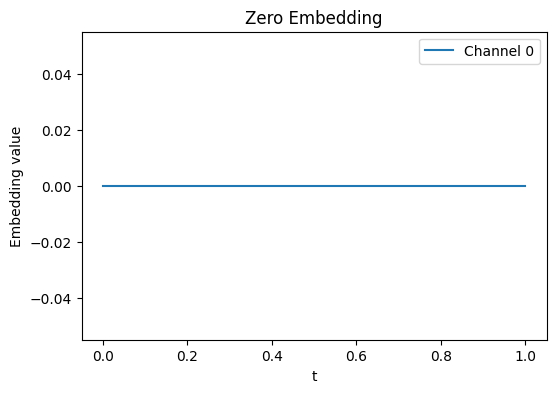

In [11]:
# TODO: visualize a few embedding channels across time to understand their patterns

"""Plot several channel of a time embedding over [0, 1]."""
for embedding in ["sinusoidal", "linear", "learnable", "identity", "zero"]:
    emb_layer = PositionalEmbedding(size=16, emb_type=embedding, scale=10.0)
    t = torch.linspace(0, 1, steps=100)
    emb = emb_layer(t).detach().cpu().numpy()

    plt.figure(figsize=(6, 4))
    for i in range(min(emb.shape[1], 8)):
        plt.plot(t.numpy(), emb[:, i], label=f"Channel {i}")
    plt.title(f"{embedding.capitalize()} Embedding")
    plt.xlabel("t")
    plt.ylabel("Embedding value")
    plt.legend()
    plt.show()

## 4. Score network (MLP)
The model predicts the added noise $\epsilon$ conditioned on $(x, y, t)$ by doing the following:
- We concatenate embeddings for $x$, $y$, and $t$.
- Feed the concatenated embeddings through a linear layer and apply GELU activation.
- Pass the result through several residual `Block`s with skip connections and GELU activations. (`hidden_layers` times)
- Finally, map to a 2D noise prediction with a linear layer.

<font color='blue'>**TODO:**</font>
- Create a residual `Block` with a skip connection plus GELU activation. `y = x + GELU(Linear(x))`
- Instantiate embeddings for `x`, `y`, and `t`, concatenate them, and map to a 2D noise prediction with an MLP.


In [12]:
# TODO: implement residual blocks and concatenate (x, y, t) embeddings
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.ff = nn.Linear(size, size)  # TODO
        self.act = nn.GELU()  # TODO

    def forward(self, x):
        return x + self.act(self.ff(x))  # TODO


class MLP(nn.Module):
    def __init__(
        self,
        hidden_size=cfg["hidden_size"],
        hidden_layers=cfg["hidden_layers"],
        emb_size=cfg["emb_size"],
        time_emb_type="sinusoidal",
        input_emb_type="sinusoidal",
    ):
        super().__init__()
        self.time_emb = PositionalEmbedding(emb_size, time_emb_type)
        self.input_emb_x = PositionalEmbedding(emb_size, input_emb_type, scale=25.0)
        self.input_emb_y = PositionalEmbedding(emb_size, input_emb_type, scale=25.0)

        concat_dim = (
            len(self.time_emb.layer)
            + len(self.input_emb_x.layer)
            + len(self.input_emb_y.layer)
        )

        layers = [nn.Linear(concat_dim, hidden_size), nn.GELU()]  # TODO
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))  # TODO
        layers.append(nn.Linear(hidden_size, 2))  # TODO

        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        x1 = self.input_emb_x(x[:, 0])  # TODO
        x2 = self.input_emb_y(x[:, 1])  # TODO
        t_emb = self.time_emb(t)  # TODO
        h = torch.cat((x1, x2, t_emb), dim=-1)  # TODO
        return self.net(h)

### 4.1. Sanity check on the MLP

<font color='blue'>**TODO:**</font>
- Run a quick forward pass on a mini batch with random timesteps to confirm tensor shapes and device placement.


<font color='blue'>**TODO:**</font> Run next cell to try your code.


In [13]:
# TODO: run a quick forward pass to check tensor shapes
model = MLP().to(device)
sample_pts = train_dataset.tensors[0][:5].to(device)
rand_t = torch.randint(0, cfg["num_timesteps"], (5,), device=device).float()
model(sample_pts, rand_t / cfg["num_timesteps"]).shape

torch.Size([5, 2])

## 5. DDPM loss and helpers
Given random timesteps $t \sim \mathcal{U}([0, T))$, noise $\epsilon \sim \mathcal{N}(0, I)$,
and $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$, the training objective is:
$$
\mathcal{L} = \mathbb{E}_{x_0, \epsilon, t} \big[ \lVert \epsilon - \epsilon_\theta(x_t, t) 
\Vert_2^2 \big].
$$

<font color='blue'>**TODO:**</font>
- Sample random timesteps per batch element. The timestep `t` should be an integer in $[0, T)$ given by `len(scheduler)`.
- Don't forget to put the random vector on the right device.


In [14]:
def sample_timesteps(batch_size, scheduler):
    return torch.randint(0, len(scheduler), (batch_size,), device=device).long()


timesteps = sample_timesteps(16, lin)
assert timesteps.shape == (16,), "Timesteps shape is incorrect"
assert timesteps.min() > 0, "Timesteps minimum value is incorrect"
assert timesteps.max() < 1000, "Timesteps maximum value is incorrect"

Now we can create a function that takes a batch of real samples `x0`, samples random timesteps, adds noise accordingly, and computes the MSE loss between the true noise and the model prediction.

<font color='blue'>**TODO:**</font>
- Implement the `forward_diffusion_sample` function to add noise to `x0` at given timesteps.
- Make sure the function returns both the noisy samples `x_t` and the true noise `ε`.

In [15]:
def forward_diffusion_sample(scheduler, x0, timesteps, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    x_t = scheduler.add_noise(x0, noise, timesteps)
    return x_t, noise


x0 = train_dataset.tensors[0][:16].to(device)
output = forward_diffusion_sample(lin, x0, timesteps)
assert len(output) == 2, "Output should be a tuple of (noisy samples, noise)"
assert output[0].shape == x0.shape, "Noisy samples shape is incorrect"
assert output[1].shape == x0.shape, "Noise shape is incorrect"

And finally, we can implement the DDPM loss function. Given a batch of real samples `x0`, we:
1. Sample random timesteps `t` for each batch element.
2. Generate noisy samples `x_t` and the true noise `ε` using `forward_diffusion_sample`.
3. Normalize timesteps to `[0, 1]` for model input.
4. Predict noise `ε_θ(x_t, t)` using the model.
5. Compute and return the MSE loss between the true noise `ε` and the predicted noise `ε_θ(x_t, t)`.

<font color='blue'>**TODO:**</font>
- Implement the `ddpm_loss` function that computes the MSE loss between the true noise and the model's predicted noise.

In [16]:
def ddpm_loss(model, scheduler, batch):
    x0 = batch.to(device)
    timesteps = sample_timesteps(x0.shape[0], scheduler)
    x_t, noise = forward_diffusion_sample(scheduler, x0, timesteps)
    t_normalized = timesteps.float() / len(scheduler)
    noise_pred = model(x_t, t_normalized)
    return F.mse_loss(noise_pred, noise)

## 6. Training loop with tqdm
We iterate over the dataloader, backpropagate the MSE, and every `eval_every`
epochs we sample a batch to monitor progress.

<font color='blue'>**TODO:**</font>
- Build a training loop that iterates with `tqdm`, calls `ddpm_loss`, and steps an Adam optimizer.
- Keep track of epoch losses and every `eval_every` epochs draw fresh samples for monitoring.


In [17]:
# TODO: implement training loop with optimizer, tqdm, and periodic sampling
def train(model, scheduler, dataloader, cfg):
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])
    losses = []
    # Use tqdm for progress bar to monitor training progress
    pg = tqdm.trange(cfg["num_epochs"], desc="Training")
    for epoch in pg:
        epoch_losses = []
        for batch in dataloader:
            optimizer.zero_grad()
            loss = ddpm_loss(model, scheduler, batch[0])
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        mean_loss = float(np.mean(epoch_losses))
        losses.append(mean_loss)
        pg.set_postfix({"loss": mean_loss})
    return losses

### 6.1. First short training run
(For a quick check you can reduce `num_epochs` or the dataset size.)

<font color='blue'>**TODO:**</font>
- Instantiate the scheduler + model with the current hyper-parameters.
- Optionally launch a reduced training run (fewer epochs) to ensure everything converges before the long job.


<font color='blue'>**TODO:**</font> Run next cell to try your code.


In [18]:
# TODO: instantiate scheduler + model and launch training when ready
main_scheduler = NoiseScheduler(
    num_timesteps=cfg["num_timesteps"],
    beta_start=cfg["beta_start"],
    beta_end=cfg["beta_end"],
    schedule_type=cfg["beta_schedule"],
)
model = MLP().to(device)
losses = train(model, main_scheduler, train_loader, cfg)

Training: 100%|██████████| 1000/1000 [00:55<00:00, 18.11it/s, loss=0.158]


## 7. Reverse diffusion and sampling
The reverse update uses:
$$
\hat{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \Big( x_t - \sqrt{1 - \bar{\alpha}_t} \; \epsilon_\theta(x_t, t) \Big),
$$
then
$$
q(x_{t-1} \mid x_t, \hat{x}_0) = \mathcal{N}(x_{t-1}; \mu_t(\hat{x}_0, x_t), \sigma_t^2 I).
$$
and 
$$
\mu_t(\hat{x}_0, x_t) = \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1 - \bar{\alpha}_t} \hat{x}_0 + \frac{\sqrt{\alpha_t} (1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t,
$$
with $\sigma_t^2 = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t$.

This step has been implemented in the `NoiseScheduler.step` method. We implement `p_sample_step` and `sample_ddpm`, and a helper to plot the final samples.

<font color='blue'>**TODO:**</font>
- Implement `p_sample_step` (single reverse update) using the `NoiseScheduler.step` method`.
- Implement `sample_ddpm` (full reverse chain) by starting from a standard Gaussian and iteratively applying `p_sample_step`.


In [19]:
# TODO: code the reverse diffusion sampler
@torch.no_grad()
def p_sample_step(model, scheduler, x_t, timesteps):
    t_normalized = timesteps.float() / len(scheduler)  # TODO
    eps_theta = model(x_t, t_normalized)  # TODO
    return scheduler.step(eps_theta, timesteps, x_t)  # TODO


@torch.no_grad()
def sample_ddpm(model, scheduler, n_samples=1024, device=device, plot=False):
    model.eval()
    x = torch.randn(n_samples, 2, device=device)
    for t in reversed(range(len(scheduler))):
        timesteps = torch.full((n_samples,), t, device=device, dtype=torch.long)
        x = p_sample_step(model, scheduler, x, timesteps)
        if t % (len(scheduler) // 10) == 0 and plot:
            scatter_data_and_samples(
                train_dataset,
                samples=x,
                title="DDPM Sampling",
                label=f"t={t}",
            )
    return x.cpu()

<font color='blue'>**TODO:**</font> Run next cell to try your code.


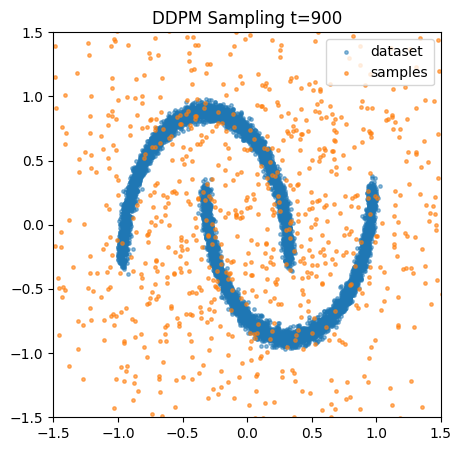

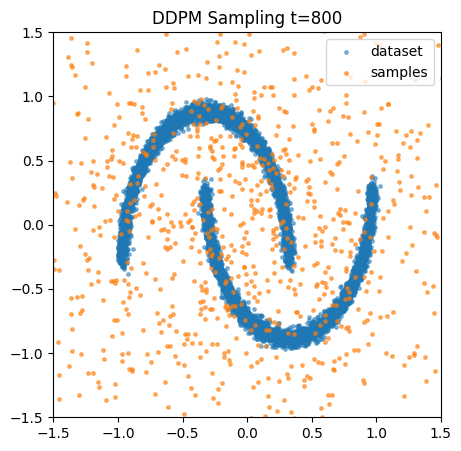

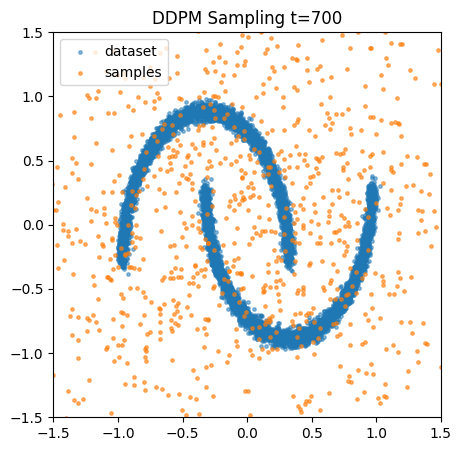

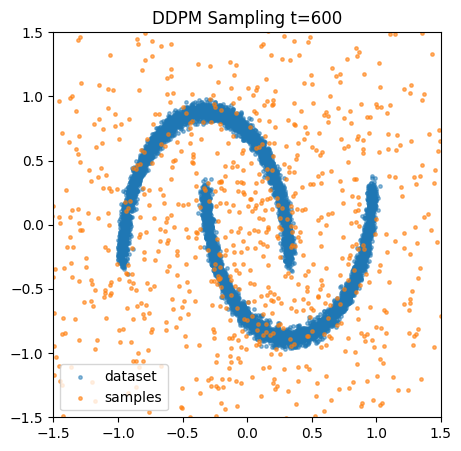

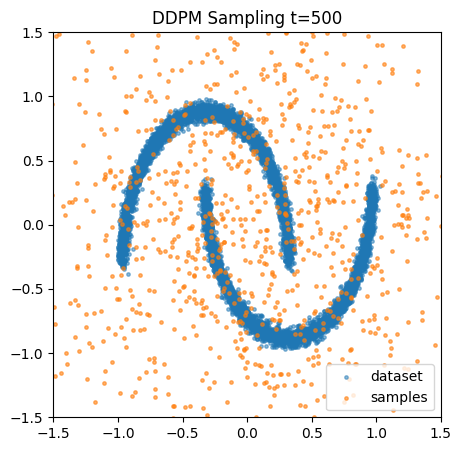

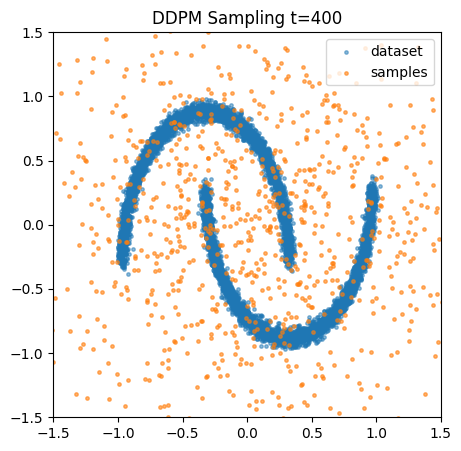

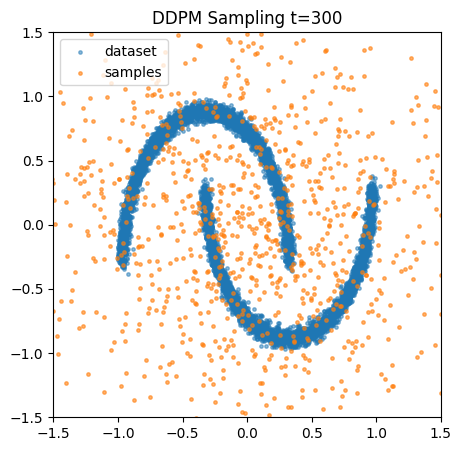

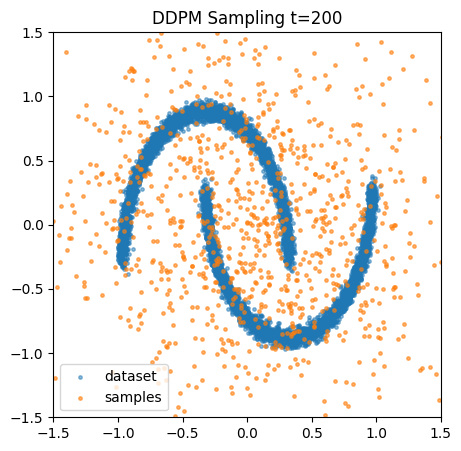

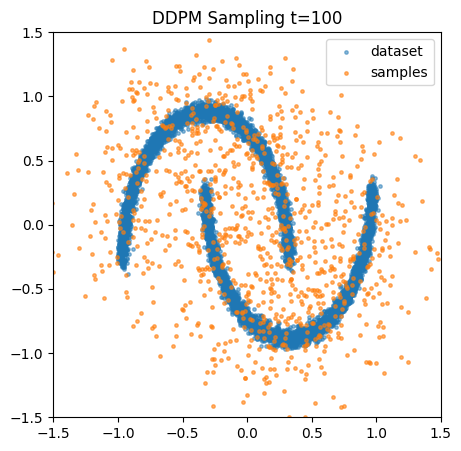

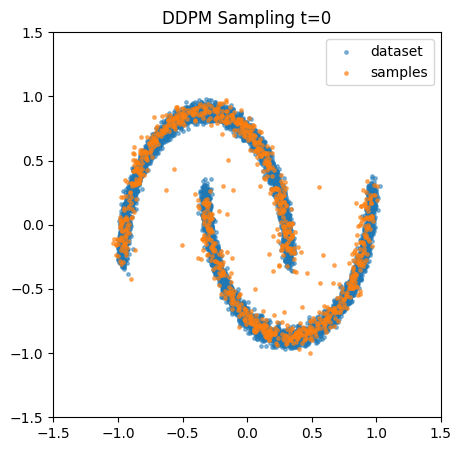

In [20]:
samples = sample_ddpm(model, main_scheduler, n_samples=1024, device=device, plot=True)

To visualize the final generated samples against the dataset, we can use the following helper function.
<font color='blue'>**TODO:**</font>
- Let us visualize what `sample_ddpm` produces after training using the helper function `compare_samples`.



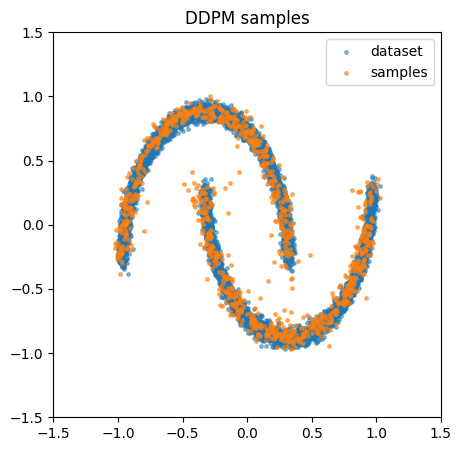

In [29]:
def compare_samples(model, scheduler, n_samples=1024, name=""):
    samples = sample_ddpm(model, scheduler, n_samples=n_samples, device=device)
    scatter_data_and_samples(train_dataset, samples, title="DDPM samples" + "")


compare_samples(model, main_scheduler, n_samples=cfg["sample_points"])

As seen in the lectures, the higher the number of denoising steps, the better the quality of the generated samples. You can experiment with different values of `num_sampling_steps` in `sample_ddpm` to observe this effect.

<font color='blue'>**TODO:**</font> Run next cell to try your code.

Sampling with 10 steps


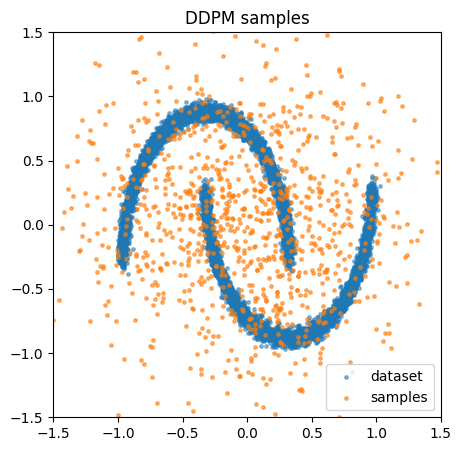

Sampling with 25 steps


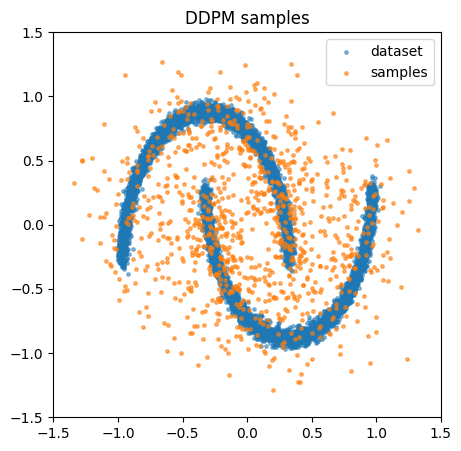

Sampling with 50 steps


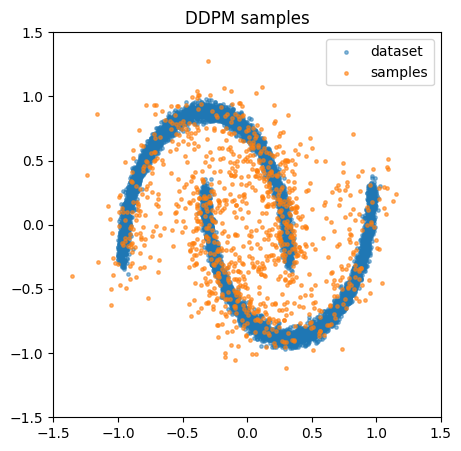

Sampling with 100 steps


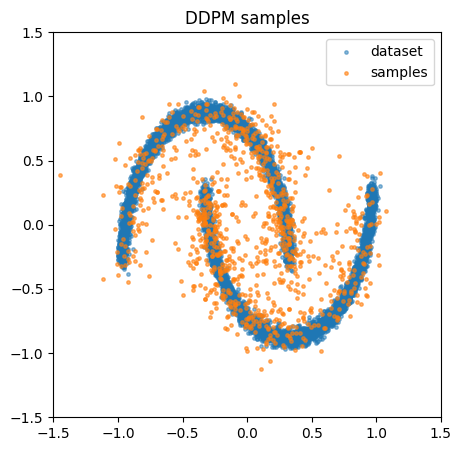

Sampling with 250 steps


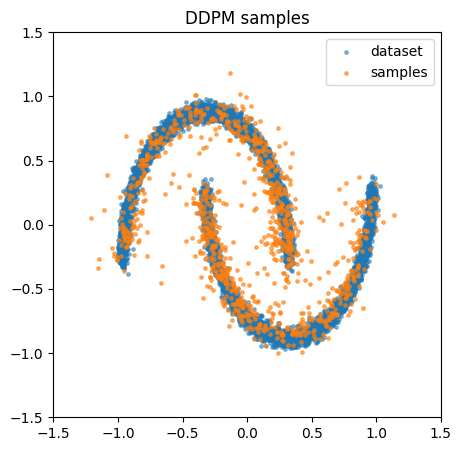

Sampling with 500 steps


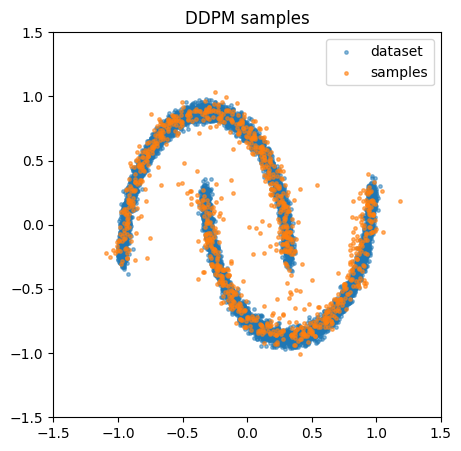

Sampling with 1000 steps


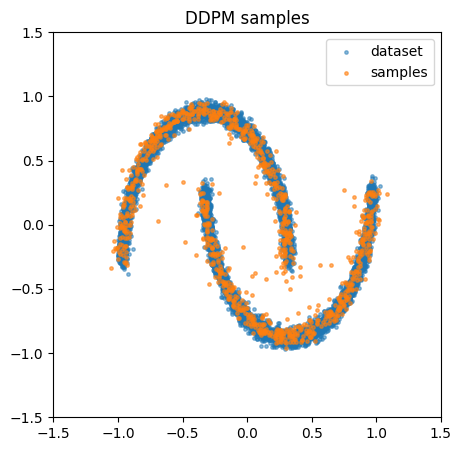

In [30]:
for num_steps in [10, 25, 50, 100, 250, 500, 1000]:
    print(f"Sampling with {num_steps} steps")
    sub_scheduler = NoiseScheduler(
        num_timesteps=num_steps,
        beta_start=cfg["beta_start"],
        beta_end=cfg["beta_end"],
        schedule_type=cfg["beta_schedule"],
    )
    compare_samples(
        model,
        sub_scheduler,
        n_samples=cfg["sample_points"],
        name=f" ({num_steps} steps)",
    )

## 8. Ablation study scaffolding
To encourage experimentation we expose a helper that trains short runs with different
embeddings and beta schedules.

<font color='blue'>**TODO:**</font>
- Write `run_ablation` to rerun short trainings with alternative embeddings or schedules and report the losses.
- Populate an `experiments` list (baseline + >=2 variants) and log/visualize the resulting samples.


<font color='blue'>**TODO:**</font> Run next cell to try your code.


Training: 100%|██████████| 200/200 [00:10<00:00, 19.10it/s, loss=0.173]


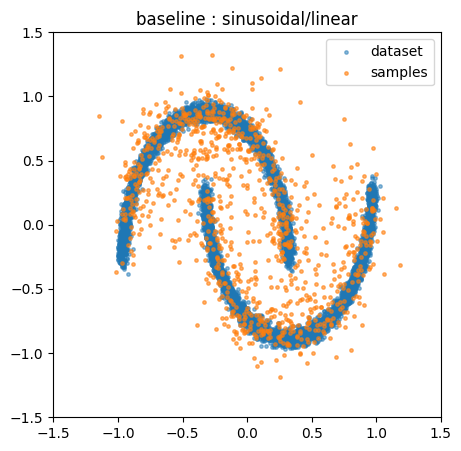

Training: 100%|██████████| 200/200 [00:10<00:00, 19.01it/s, loss=0.174]


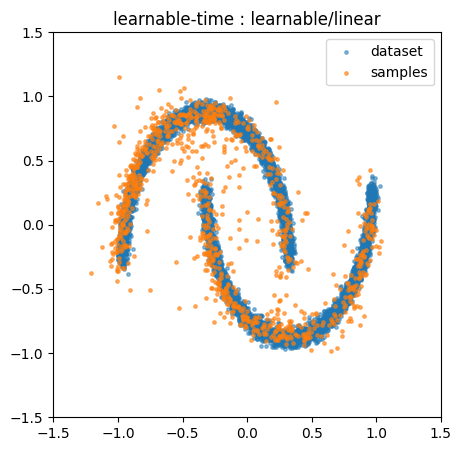

Training: 100%|██████████| 200/200 [00:11<00:00, 17.99it/s, loss=0.181]


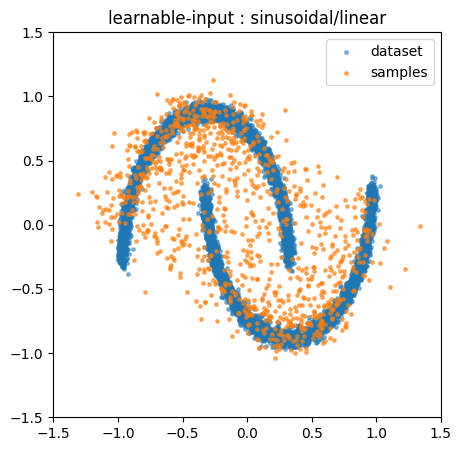

Training: 100%|██████████| 200/200 [00:11<00:00, 16.86it/s, loss=0.172]


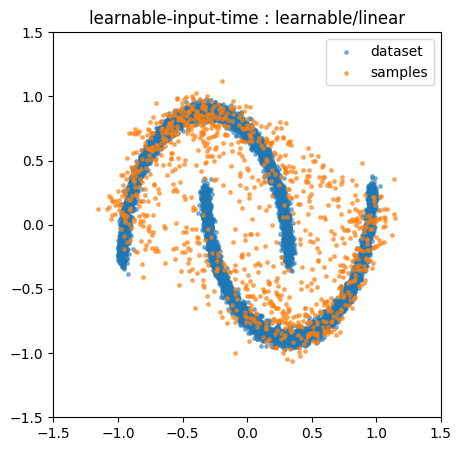

In [22]:
# TODO: relaunch short experiments with variant embeddings / schedules
def run_ablation(
    time_emb="sinusoidal",
    input_emb="sinusoidal",
    schedule="linear",
    epochs=400,
    name="",
):
    local_cfg = cfg.copy()
    local_cfg["num_epochs"] = epochs
    scheduler = NoiseScheduler(
        num_timesteps=local_cfg["num_timesteps"],
        beta_start=local_cfg["beta_start"],
        beta_end=local_cfg["beta_end"],
        schedule_type=schedule,
    )
    model = MLP(time_emb_type=time_emb, input_emb_type=input_emb).to(device)
    ablation_loader = DataLoader(
        train_dataset,
        batch_size=local_cfg["batch_size"],
        shuffle=True,
        drop_last=True,
    )
    losses = train(model, scheduler, ablation_loader, local_cfg)
    samples = sample_ddpm(
        model, scheduler, n_samples=local_cfg["sample_points"], device=device
    )
    scatter_data_and_samples(
        train_dataset, samples, title=f"{name} : {time_emb}/{schedule}"
    )
    return {"model": model, "losses": losses, "scheduler": scheduler}


experiments = [
    {
        "name": "baseline",
        "time_emb": "sinusoidal",
        "input_emb": "sinusoidal",
        "schedule": "linear",
    },
    {
        "name": "learnable-time",
        "time_emb": "learnable",
        "input_emb": "sinusoidal",
        "schedule": "linear",
    },
    {
        "name": "learnable-input",
        "time_emb": "sinusoidal",
        "input_emb": "learnable",
        "schedule": "linear",
    },
    {
        "name": "learnable-input-time",
        "time_emb": "learnable",
        "input_emb": "learnable",
        "schedule": "linear",
    },
]
results = {exp["name"]: run_ablation(**exp, epochs=200) for exp in experiments}

We can compare the final losses across experiments.

<font color='blue'>**TODO:**</font>
- Display the final losses for each experiment to compare performance across different configurations.

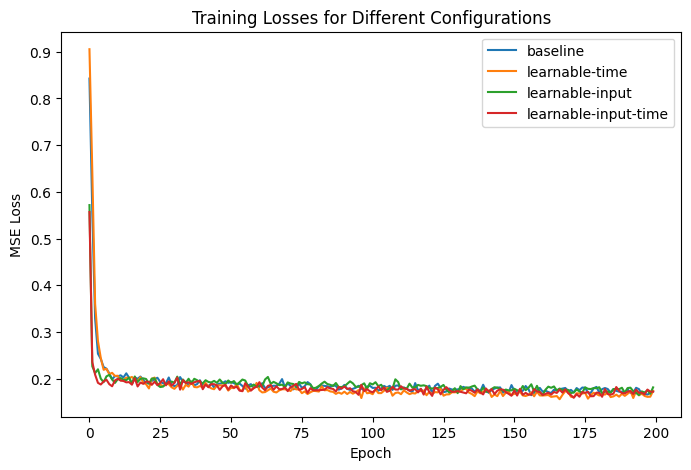

In [23]:
def plot_losses(results):
    plt.figure(figsize=(8, 5))
    for name, output in results.items():
        losses = output["losses"]
        plt.plot(losses, label=name)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training Losses for Different Configurations")
    plt.legend()
    plt.show()


plot_losses(results)

To continue the evaluation, we can build a function to assess the model per noise level. This function should sample points from the dataset, add noise at a specific timestem and evaluate the model's denoising performance.

<font color='blue'>**TODO:**</font>
- Implement a function to evaluate the model's denoising performance at different noise levels by adding noise to sampled data points and measuring reconstruction quality.


In [24]:
def evaluate_denoising_performance(
    model, scheduler, dataset, noise_levels, n_samples=256
):
    model.eval()
    x0 = dataset.tensors[0]
    idx = torch.randperm(len(x0))[:n_samples]
    x0 = x0[idx].to(device)

    normalized_timesteps = []
    performance = []
    for noise_level in noise_levels:
        t = int(noise_level * (len(scheduler) - 1))
        timesteps = torch.full((n_samples,), t, device=device, dtype=torch.long)
        noise = torch.randn_like(x0)
        x_t = scheduler.add_noise(x0, noise, timesteps)
        t_normalized = timesteps.float() / len(scheduler)
        noise_pred = model(x_t, t_normalized)
        mse = F.mse_loss(noise_pred, noise).item()
        performance.append(mse)
        normalized_timesteps.append(noise_level)
    return normalized_timesteps, performance

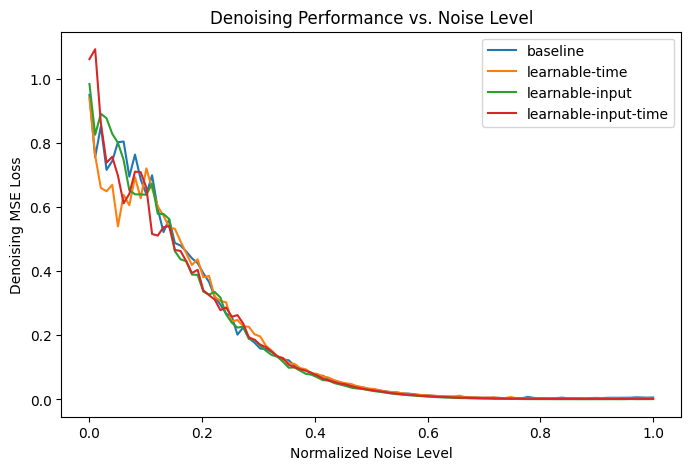

In [25]:
def plot_losses_vs_noise_levels(results):
    noise_levels = np.linspace(0, 1, 100)
    plt.figure(figsize=(8, 5))
    for name, output in results.items():
        model = output["model"]
        scheduler = output["scheduler"]
        timesteps, performance = evaluate_denoising_performance(
            model, scheduler, train_dataset, noise_levels
        )
        plt.plot(timesteps, performance, label=name)
    plt.xlabel("Normalized Noise Level")
    plt.ylabel("Denoising MSE Loss")
    plt.title("Denoising Performance vs. Noise Level")
    plt.legend()
    plt.show()


plot_losses_vs_noise_levels(results)

Now compare the different scheduling stategies with a fixed time/ input embedding. 

<font color='blue'>**TODO:**</font>
- Run the ablation experiments and plot the losses and denoising performance across noise levels for each configuration.

Training: 100%|██████████| 200/200 [00:11<00:00, 17.87it/s, loss=0.171]


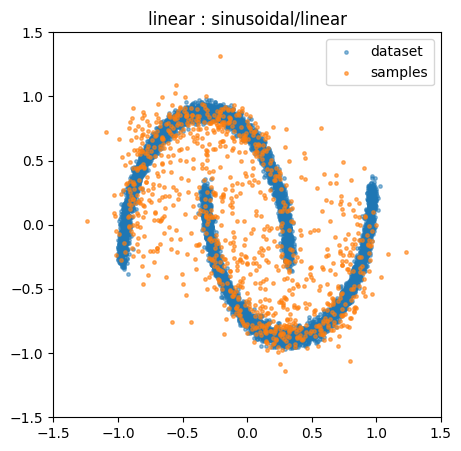

Training: 100%|██████████| 200/200 [00:10<00:00, 18.22it/s, loss=0.262]


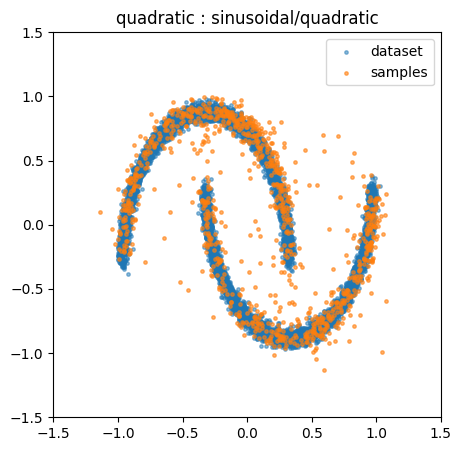

Training: 100%|██████████| 200/200 [00:11<00:00, 17.57it/s, loss=0.303]


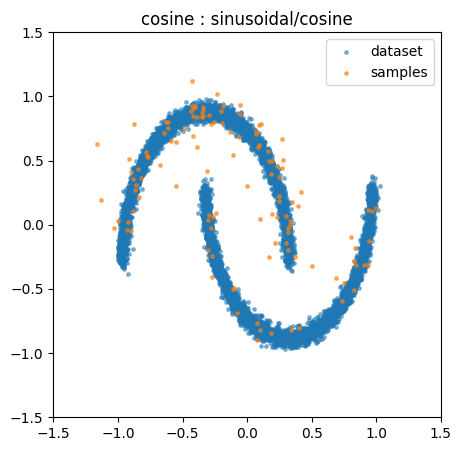

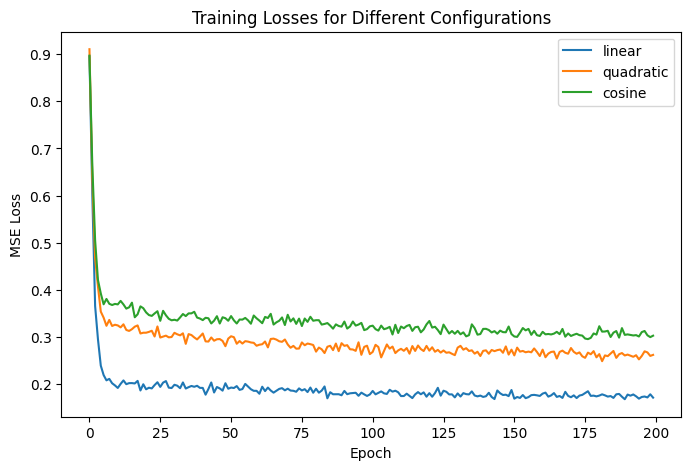

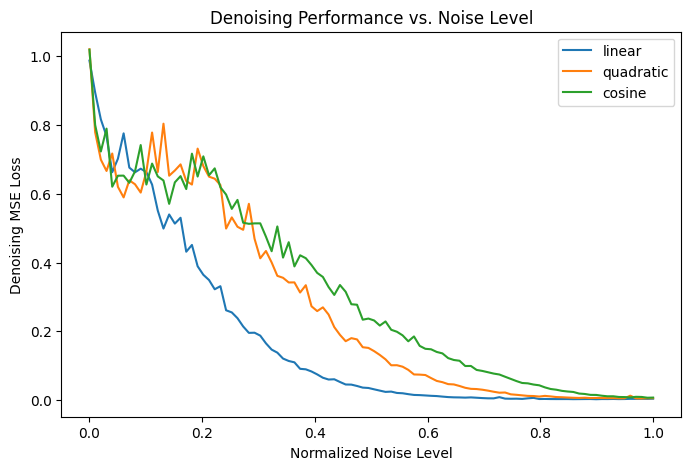

In [26]:
experiments = [
    {
        "name": "linear",
        "time_emb": "sinusoidal",
        "input_emb": "sinusoidal",
        "schedule": "linear",
    },
    {
        "name": "quadratic",
        "time_emb": "sinusoidal",
        "input_emb": "sinusoidal",
        "schedule": "quadratic",
    },
    {
        "name": "cosine",
        "time_emb": "sinusoidal",
        "input_emb": "sinusoidal",
        "schedule": "cosine",
    },
]  # TODO

results = {exp["name"]: run_ablation(**exp, epochs=200) for exp in experiments}
plot_losses(results)
plot_losses_vs_noise_levels(results)